# Hidden Markov model for stock price prediction

## Installation

In [ ]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.6 MB/s eta 0:00:00


## HMM Predictor

Les HMM (Hidden Markov Models) sont capables de modéliser les transitions d'état caché à partir des données observées séquentielles. Le problème de la prédiction des actions peut également être pensé selon le même schéma. Le prix de l'action dépend d'une multitude de facteurs, qui restent généralement invisibles pour l'investisseur (variables cachées).

La transition entre les facteurs sous-jacents change en fonction de la politique et des décisions de l'entreprise, de ses conditions financières et des décisions de gestion, et celles-ci affectent le prix de l'action (données observées). Ainsi, les HMM sont parfaitement adaptés au problème de la prédiction des prix.

On pourra prédire les prix des actions d'Alphabet Inc. (GOOGL), de Facebook (FB) et d'Apple Inc. (AAPL) avec les HMM.


In [ ]:
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from hmmlearn.hmm import GaussianHMM,GMMHMM
from hmmlearn.base import ConvergenceMonitor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import yfinance as yf



# Supress warning in hmmlearn
warnings.filterwarnings("ignore")
# Change plot style to ggplot (for better and more aesthetic visualisation)
plt.style.use('ggplot')


from hmmlearn import hmm

class ThresholdMonitor(ConvergenceMonitor):
    @property
    def converged(self):
        return (self.iter == self.n_iter or
                self.history[-1] >= self.tol)

class StockPredictor(object):
    def __init__(self, company, test_size=0.2,
                 n_hidden_states=4, n_latency_days=10,
                 n_steps_frac_change=70, n_steps_frac_high=10,
                 n_steps_frac_low=10, n_iter = 50):
        self._init_logger()

        self.company = company
        self.n_latency_days = n_latency_days

        self.hmm = GMMHMM(n_components=n_hidden_states, covariance_type='full', n_iter = n_iter, tol = 1e-5, verbose = True)

        self.hmm.monitor_ = ThresholdMonitor(self.hmm.monitor_.tol,
                                self.hmm.monitor_.n_iter, self.hmm.monitor_.verbose)
        self._split_train_test_data(test_size)

        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)

    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)

    def _split_train_test_data(self, test_size):
        data = yf.download(self.company, start="2021-02-10", end="2023-01-21")
        _train_data, test_data = train_test_split(
            data, test_size=test_size, shuffle=False)

        self._train_data = _train_data
        self._test_data = test_data

    @staticmethod
    def _extract_features(data):


        open_price = np.array(data['Open'])
        close_price = np.array(data['Close'])
        high_price = np.array(data['High'])
        low_price = np.array(data['Low'])

        # Compute the fraction change in close, high and low prices
        # which would be used a feature
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price

        return np.column_stack((frac_change, frac_high, frac_low))

    def fit(self):
        self._logger.info('>>> Extracting Features')
        feature_vector = StockPredictor._extract_features(self._train_data)
        self._logger.info('Features extraction Completed <<<')

        self.hmm.fit(feature_vector)

    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low):
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)

        self._possible_outcomes = np.array(list(itertools.product(
            frac_change_range, frac_high_range, frac_low_range)))

    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_end_index: previous_data_start_index]
        previous_data_features = StockPredictor._extract_features(
            previous_data)

        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]

        return most_probable_outcome

    def predict_close_price(self, day_index):
        open_price = self._test_data.iloc[day_index]['Open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(
            day_index)
        return open_price * (1 + predicted_frac_change)

    def predict_close_prices_for_days(self, with_plot=False):
        predicted_close_prices = []
        test_data = self._test_data
        days = np.array(test_data.index, dtype="datetime64[ms]")

        for day_index in tqdm(range(len(days))):
            predicted_close_prices.append(self.predict_close_price(day_index))


        actual_close_prices = test_data['Close']

        actual_prices = np.array(actual_close_prices)
        predicted_prices = np.array(predicted_close_prices)

        mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

        actual_direction = np.sign(np.diff(actual_prices))
        predicted_direction = np.sign(np.diff(predicted_prices))

        correct_predictions = np.sum(actual_direction == predicted_direction)
        total_predictions = len(actual_direction)

        dpa = (correct_predictions / total_predictions) * 100
        self._logger.info(f'Prediction on {len(days)} days for the test <<<')
        metric = {"MAPE": mape, "DPA": dpa}
        if with_plot:


            fig = plt.figure(figsize=(14,8))

            axes = fig.add_subplot(111)
            axes.plot(days, actual_close_prices, 'bo-', label="actual")
            axes.plot(days, predicted_close_prices, 'r+-', label="predicted")
            axes.set_title('{company}'.format(company=self.company))

            fig.autofmt_xdate()

            plt.legend()
            plt.show()

        return predicted_close_prices, metric


    def predict_market_regime(self):
    # Obtenir les probabilités des états cachés pour chaque point de données dans l'ensemble de test
        probabilities = self.hmm.predict_proba(self._extract_features(self._test_data))
    # Déterminer le régime de marché avec la probabilité la plus élevée pour chaque jour
        market_regime = np.argmax(probabilities, axis=1)
        return market_regime

[*********************100%%**********************]  1 of 1 completed
2024-03-11 09:35:54,043 __main__     INFO     >>> Extracting Features
INFO:__main__:>>> Extracting Features
2024-03-11 09:35:54,051 __main__     INFO     Features extraction Completed <<<
INFO:__main__:Features extraction Completed <<<
         1    2716.65290681             +nan
100%|██████████| 98/98 [16:57<00:00, 10.38s/it]
2024-03-11 09:52:52,146 __main__     INFO     Prediction on 98 days for the test <<<
INFO:__main__:Prediction on 98 days for the test <<<


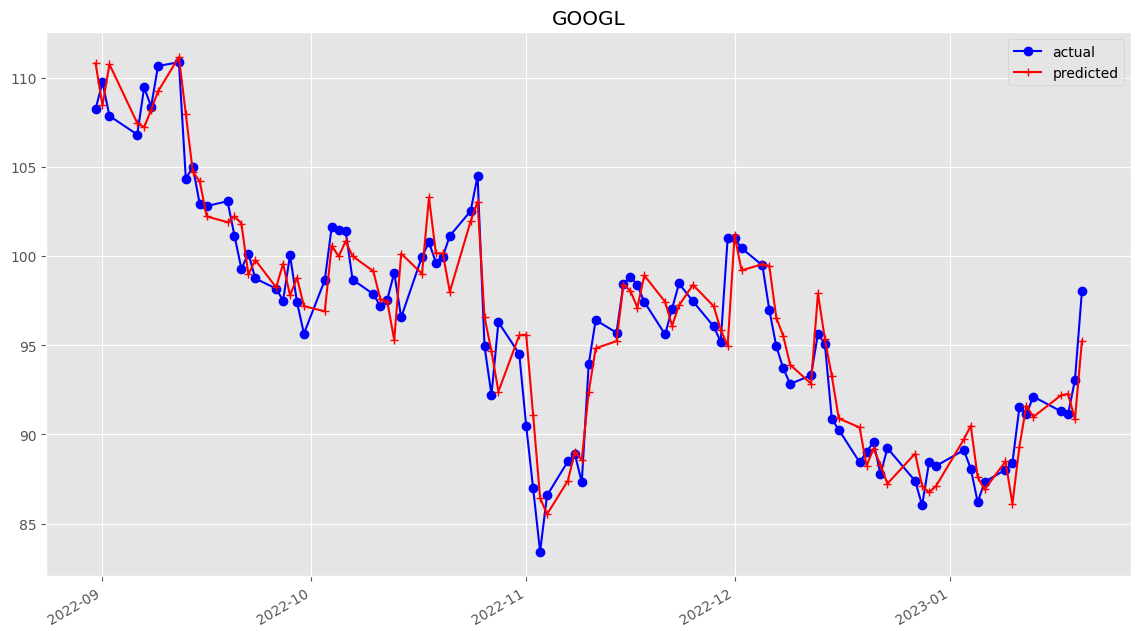

({'MAPE': 1.5452202553356182, 'DPA': 52.57731958762887},)


[*********************100%%**********************]  1 of 1 completed
2024-03-11 09:52:52,936 __main__     INFO     >>> Extracting Features
2024-03-11 09:52:52,936 __main__     INFO     >>> Extracting Features
INFO:__main__:>>> Extracting Features
2024-03-11 09:52:52,943 __main__     INFO     Features extraction Completed <<<
2024-03-11 09:52:52,943 __main__     INFO     Features extraction Completed <<<
INFO:__main__:Features extraction Completed <<<
         1    2834.91489496             +nan
100%|██████████| 98/98 [17:09<00:00, 10.50s/it]
2024-03-11 10:10:02,091 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 10:10:02,091 __main__     INFO     Prediction on 98 days for the test <<<
INFO:__main__:Prediction on 98 days for the test <<<


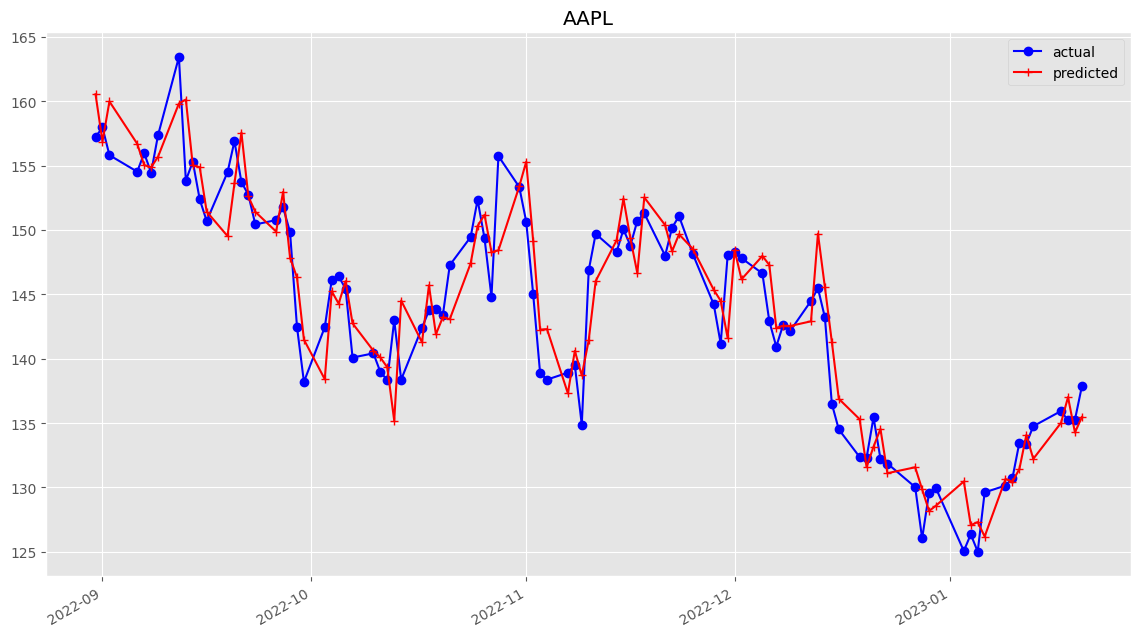

({'MAPE': 1.6199292061663424, 'DPA': 58.76288659793815},)


[*********************100%%**********************]  1 of 1 completed
2024-03-11 10:10:02,815 __main__     INFO     >>> Extracting Features
2024-03-11 10:10:02,815 __main__     INFO     >>> Extracting Features
2024-03-11 10:10:02,815 __main__     INFO     >>> Extracting Features
INFO:__main__:>>> Extracting Features
2024-03-11 10:10:02,823 __main__     INFO     Features extraction Completed <<<
2024-03-11 10:10:02,823 __main__     INFO     Features extraction Completed <<<
2024-03-11 10:10:02,823 __main__     INFO     Features extraction Completed <<<
INFO:__main__:Features extraction Completed <<<
         1    2879.09782135             +nan
100%|██████████| 98/98 [17:18<00:00, 10.60s/it]
2024-03-11 10:27:21,304 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 10:27:21,304 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 10:27:21,304 __main__     INFO     Prediction on 98 days for the test <<<
INFO:__main__:Prediction on 98 days for the tes

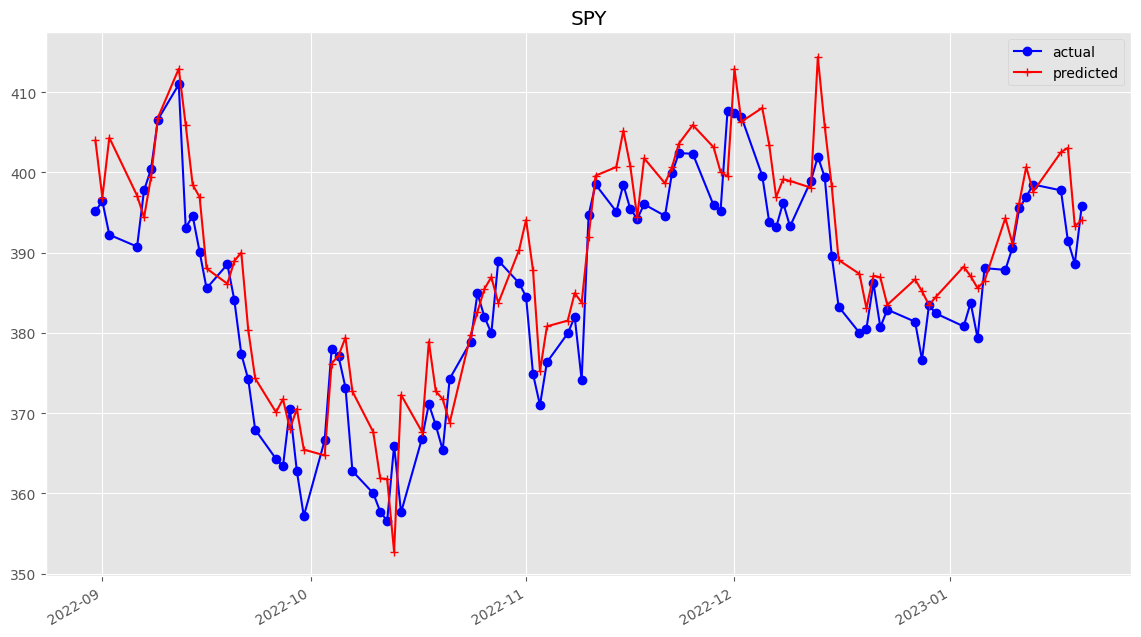

({'MAPE': 1.330568625578477, 'DPA': 58.76288659793815},)


In [ ]:
companies = ["GOOGL","AAPL","SPY"]

for company in companies:
  stock_predictor = StockPredictor(company=company)
  stock_predictor.fit()
  print(stock_predictor.predict_close_prices_for_days(with_plot=True)[1:])

[*********************100%%**********************]  1 of 1 completed
2024-03-06 13:50:59,286 __main__     INFO     >>> Extracting Features
2024-03-06 13:50:59,286 __main__     INFO     >>> Extracting Features
2024-03-06 13:50:59,286 __main__     INFO     >>> Extracting Features
2024-03-06 13:50:59,286 __main__     INFO     >>> Extracting Features
2024-03-06 13:50:59,286 __main__     INFO     >>> Extracting Features
2024-03-06 13:50:59,286 __main__     INFO     >>> Extracting Features
2024-03-06 13:50:59,286 __main__     INFO     >>> Extracting Features
2024-03-06 13:50:59,286 __main__     INFO     >>> Extracting Features
2024-03-06 13:50:59,286 __main__     INFO     >>> Extracting Features
INFO:__main__:>>> Extracting Features
2024-03-06 13:50:59,300 __main__     INFO     Features extraction Completed <<<
2024-03-06 13:50:59,300 __main__     INFO     Features extraction Completed <<<
2024-03-06 13:50:59,300 __main__     INFO     Features extraction Completed <<<
2024-03-06 13:50:59,300

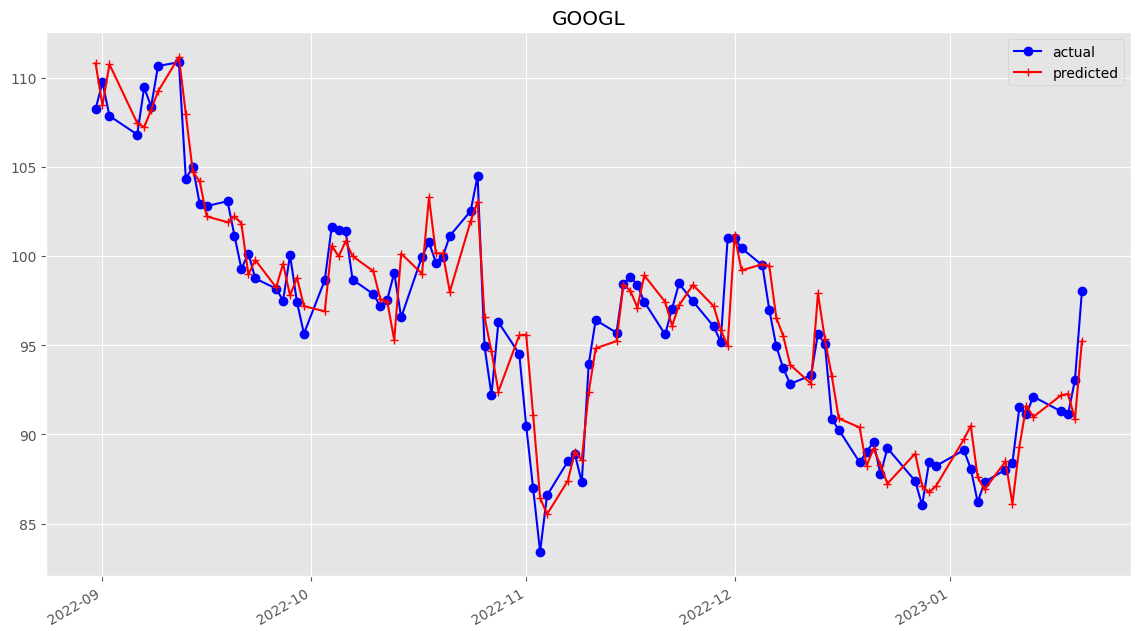

[*********************100%%**********************]  1 of 1 completed
2024-03-06 14:02:14,024 __main__     INFO     >>> Extracting Features
2024-03-06 14:02:14,024 __main__     INFO     >>> Extracting Features
2024-03-06 14:02:14,024 __main__     INFO     >>> Extracting Features
2024-03-06 14:02:14,024 __main__     INFO     >>> Extracting Features
2024-03-06 14:02:14,024 __main__     INFO     >>> Extracting Features
2024-03-06 14:02:14,024 __main__     INFO     >>> Extracting Features
2024-03-06 14:02:14,024 __main__     INFO     >>> Extracting Features
2024-03-06 14:02:14,024 __main__     INFO     >>> Extracting Features
2024-03-06 14:02:14,024 __main__     INFO     >>> Extracting Features
2024-03-06 14:02:14,024 __main__     INFO     >>> Extracting Features
INFO:__main__:>>> Extracting Features
2024-03-06 14:02:14,070 __main__     INFO     Features extraction Completed <<<
2024-03-06 14:02:14,070 __main__     INFO     Features extraction Completed <<<
2024-03-06 14:02:14,070 __main__ 

({'MAPE': 1.5452202553356182, 'DPA': 52.57731958762887},)
État caché 0:
Nombre d'observations : 48
Moyenne des données : [-0.00466368  0.01133797  0.01628561]
Écart-type des données : [0.01706552 0.00852308 0.01151327]
Minimum des données : [-0.04365517  0.          0.00045845]
Maximum des données : [0.02837863 0.03185625 0.04464488]

État caché 1:
Nombre d'observations : 50
Moyenne des données : [0.00410327 0.01714065 0.01112401]
Écart-type des données : [0.02017465 0.01274026 0.00971155]
Minimum des données : [-0.05217387  0.00114323  0.        ]
Maximum des données : [0.06507064 0.06559799 0.05322152]



         1    2814.79256347             +nan
100%|██████████| 98/98 [11:02<00:00,  6.76s/it]
2024-03-06 14:13:17,061 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:13:17,061 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:13:17,061 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:13:17,061 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:13:17,061 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:13:17,061 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:13:17,061 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:13:17,061 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:13:17,061 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:13:17,061 __main__     INFO     Prediction on 98 days for the test <<<
INFO:__main__:Prediction on 98 days for the test <<<


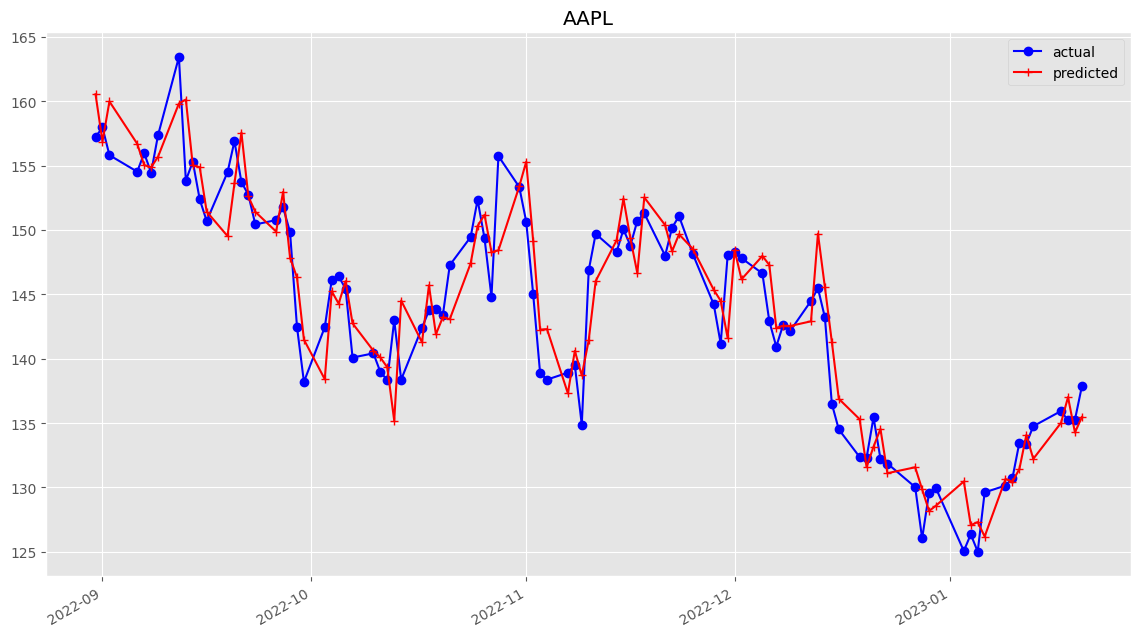

[*********************100%%**********************]  1 of 1 completed
2024-03-06 14:13:17,525 __main__     INFO     >>> Extracting Features
2024-03-06 14:13:17,525 __main__     INFO     >>> Extracting Features
2024-03-06 14:13:17,525 __main__     INFO     >>> Extracting Features
2024-03-06 14:13:17,525 __main__     INFO     >>> Extracting Features
2024-03-06 14:13:17,525 __main__     INFO     >>> Extracting Features
2024-03-06 14:13:17,525 __main__     INFO     >>> Extracting Features
2024-03-06 14:13:17,525 __main__     INFO     >>> Extracting Features
2024-03-06 14:13:17,525 __main__     INFO     >>> Extracting Features
2024-03-06 14:13:17,525 __main__     INFO     >>> Extracting Features
2024-03-06 14:13:17,525 __main__     INFO     >>> Extracting Features
2024-03-06 14:13:17,525 __main__     INFO     >>> Extracting Features
INFO:__main__:>>> Extracting Features
2024-03-06 14:13:17,559 __main__     INFO     Features extraction Completed <<<
2024-03-06 14:13:17,559 __main__     INFO  

({'MAPE': 1.6199292061663424, 'DPA': 58.76288659793815},)
État caché 0:
Nombre d'observations : 1
Moyenne des données : [-0.01927513  0.00168426  0.01977418]
Écart-type des données : [0. 0. 0.]
Minimum des données : [-0.01927513  0.00168426  0.01977418]
Maximum des données : [-0.01927513  0.00168426  0.01977418]

État caché 1:
Nombre d'observations : 97
Moyenne des données : [-0.00027205  0.01418775  0.01509576]
Écart-type des données : [0.02006879 0.01241979 0.01174295]
Minimum des données : [-0.04109204  0.00022834  0.00013366]
Maximum des données : [0.05926365 0.06370835 0.05426132]



         1    2915.97727442             +nan
100%|██████████| 98/98 [10:50<00:00,  6.64s/it]
2024-03-06 14:24:07,986 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:24:07,986 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:24:07,986 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:24:07,986 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:24:07,986 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:24:07,986 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:24:07,986 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:24:07,986 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:24:07,986 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:24:07,986 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-06 14:24:07,986 __main__     INFO     Prediction 

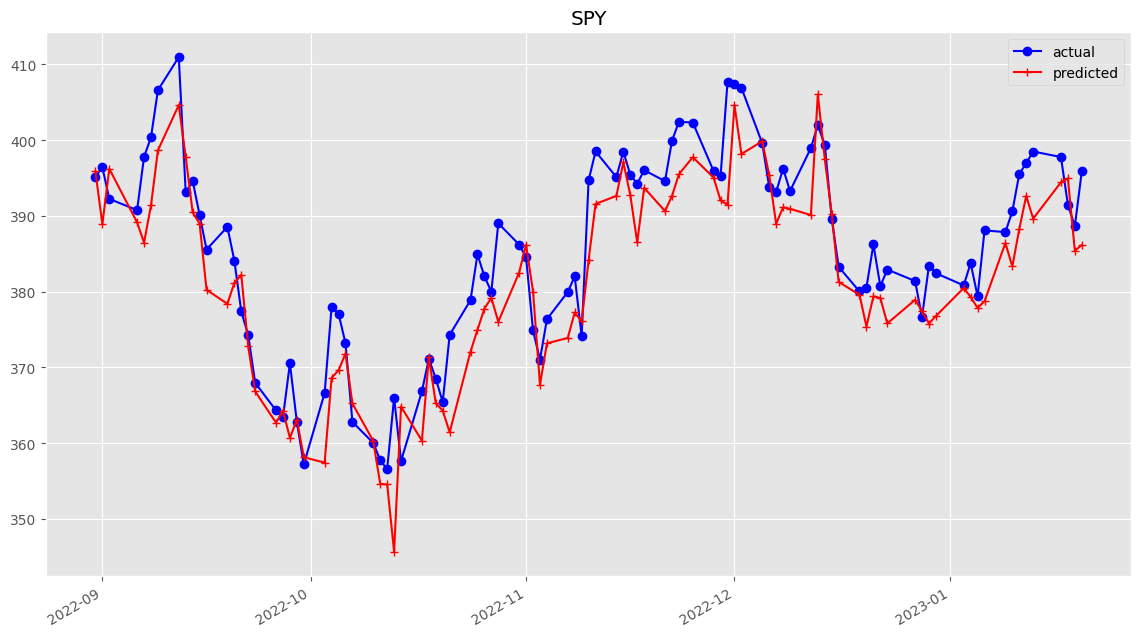

({'MAPE': 1.2424482260353282, 'DPA': 58.76288659793815},)
État caché 0:
Nombre d'observations : 95
Moyenne des données : [0.00064362 0.00877447 0.00894896]
Écart-type des données : [0.01197752 0.00767843 0.00680189]
Minimum des données : [-0.02258416  0.00010796  0.00020933]
Maximum des données : [0.04799407 0.05240405 0.02718052]

État caché 1:
Nombre d'observations : 3
Moyenne des données : [-0.02167614  0.00674546  0.0224943 ]
Écart-type des données : [0.00736399 0.00398161 0.00790153]
Minimum des données : [-0.02962958  0.00327557  0.0122271 ]
Maximum des données : [-0.01187708  0.01232095  0.03144756]



In [ ]:
companies = ["GOOGL","AAPL","SPY"]
def analyze_hidden_states(model, test_data):
    # Prédire les états cachés pour les données de test
    hidden_states = model.predict(test_data)

    # Créer un dictionnaire pour stocker les sous-ensembles de données pour chaque état caché
    hidden_state_data = {state: [] for state in np.unique(hidden_states)}

    # Diviser les données de test en sous-ensembles correspondant à chaque état caché
    for i, state in enumerate(hidden_states):
        hidden_state_data[state].append(test_data[i])

    # Analyser les caractéristiques des données dans chaque sous-ensemble
    for state, data in hidden_state_data.items():
        state_data = np.array(data)
        print(f"État caché {state}:")
        print(f"Nombre d'observations : {len(state_data)}")
        print(f"Moyenne des données : {np.mean(state_data, axis=0)}")
        print(f"Écart-type des données : {np.std(state_data, axis=0)}")
        print(f"Minimum des données : {np.min(state_data, axis=0)}")
        print(f"Maximum des données : {np.max(state_data, axis=0)}")
        print()

for company in companies:
  stock_predictor = StockPredictor(company=company,  n_hidden_states=2)
  stock_predictor.fit()
  print(stock_predictor.predict_close_prices_for_days(with_plot=True)[1:])
  analyze_hidden_states(stock_predictor.hmm, stock_predictor._extract_features(stock_predictor._test_data))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to fit the HMM and compute metrics
def fit_and_compute_metrics(n_hidden_states, train_data, n_steps_frac_change, n_steps_frac_high, n_steps_frac_low):
    mape_history = []
    dpa_history = []

    for n_iter in range(5, 76, 10):
        hmm = GMMHMM(n_components=n_hidden_states, covariance_type='full', n_iter=n_iter, tol=1e-6, verbose=True)
        hmm.monitor_ = ThresholdMonitor(hmm.monitor_.tol, hmm.monitor_.n_iter, hmm.monitor_.verbose)

        # Fit the HMM
        feature_vector = StockPredictor._extract_features(train_data)
        hmm.fit(feature_vector)

        # Compute metrics
        predictor = StockPredictor(company = "GOOGL")
        predictor.hmm = hmm
        predicted_close_prices, metric = predictor.predict_close_prices_for_days(with_plot=False)
        mape = metric["MAPE"]
        dpa = metric["DPA"]

        mape_history.append(mape)
        dpa_history.append(dpa)

        print(f"Iteration {n_iter}: MAPE={mape}, DPA={dpa}")

    return mape_history, dpa_history

# Set your parameters
company = "GOOGL"
test_size = 0.2
n_hidden_states = 4
n_latency_days = 10
n_steps_frac_change = 50
n_steps_frac_high = 10
n_steps_frac_low = 10

# Load your data
data = yf.download(company, start="2021-02-10", end="2023-01-21")
train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)

# Fit the HMM and compute metrics
mape_history, dpa_history = fit_and_compute_metrics(n_hidden_states, train_data, n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)




[*********************100%%**********************]  1 of 1 completed
         1    2780.15964707             +nan
[*********************100%%**********************]  1 of 1 completed
100%|██████████| 98/98 [16:59<00:00, 10.40s/it]
2024-03-11 10:44:21,893 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 10:44:21,893 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 10:44:21,893 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 10:44:21,893 __main__     INFO     Prediction on 98 days for the test <<<
INFO:__main__:Prediction on 98 days for the test <<<
         1    2783.84553411             +nan
[*********************100%%**********************]  1 of 1 completed


Iteration 5: MAPE=1.5286164217708558, DPA=52.57731958762887


100%|██████████| 98/98 [17:06<00:00, 10.47s/it]
2024-03-11 11:01:28,555 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:01:28,555 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:01:28,555 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:01:28,555 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:01:28,555 __main__     INFO     Prediction on 98 days for the test <<<
INFO:__main__:Prediction on 98 days for the test <<<
         1    2709.44940325             +nan
[*********************100%%**********************]  1 of 1 completed


Iteration 15: MAPE=1.5452202553356182, DPA=52.57731958762887


100%|██████████| 98/98 [17:04<00:00, 10.45s/it]
2024-03-11 11:18:32,924 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:18:32,924 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:18:32,924 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:18:32,924 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:18:32,924 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:18:32,924 __main__     INFO     Prediction on 98 days for the test <<<
INFO:__main__:Prediction on 98 days for the test <<<
         1    2745.04099890             +nan
[*********************100%%**********************]  1 of 1 completed


Iteration 25: MAPE=1.5452202553356182, DPA=52.57731958762887


100%|██████████| 98/98 [17:11<00:00, 10.52s/it]
2024-03-11 11:35:44,055 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:35:44,055 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:35:44,055 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:35:44,055 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:35:44,055 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:35:44,055 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:35:44,055 __main__     INFO     Prediction on 98 days for the test <<<
INFO:__main__:Prediction on 98 days for the test <<<
         1    2765.58109219             +nan
[*********************100%%**********************]  1 of 1 completed


Iteration 35: MAPE=1.5452202553356182, DPA=52.57731958762887


100%|██████████| 98/98 [17:09<00:00, 10.50s/it]
2024-03-11 11:52:53,290 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:52:53,290 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:52:53,290 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:52:53,290 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:52:53,290 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:52:53,290 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:52:53,290 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 11:52:53,290 __main__     INFO     Prediction on 98 days for the test <<<
INFO:__main__:Prediction on 98 days for the test <<<


Iteration 45: MAPE=1.5452202553356182, DPA=52.57731958762887


         1    2721.17208982             +nan
[*********************100%%**********************]  1 of 1 completed
100%|██████████| 98/98 [17:27<00:00, 10.69s/it]
2024-03-11 12:10:21,196 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:10:21,196 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:10:21,196 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:10:21,196 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:10:21,196 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:10:21,196 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:10:21,196 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:10:21,196 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:10:21,196 __main__     INFO     Prediction on 98 days for the test <<<
INFO:__main__:Prediction on 98 days for the test <<<
         1    2728.2

Iteration 55: MAPE=1.5452202553356182, DPA=52.57731958762887


100%|██████████| 98/98 [17:10<00:00, 10.51s/it]
2024-03-11 12:27:31,470 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:27:31,470 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:27:31,470 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:27:31,470 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:27:31,470 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:27:31,470 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:27:31,470 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:27:31,470 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:27:31,470 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:27:31,470 __main__     INFO     Prediction on 98 days for the test <<<
INFO:__main__:Prediction on 98 days for the test <<<
         1    2783.96398711             +nan
[***

Iteration 65: MAPE=1.5452202553356182, DPA=52.57731958762887


100%|██████████| 98/98 [17:06<00:00, 10.47s/it]
2024-03-11 12:44:37,712 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:44:37,712 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:44:37,712 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:44:37,712 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:44:37,712 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:44:37,712 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:44:37,712 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:44:37,712 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:44:37,712 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:44:37,712 __main__     INFO     Prediction on 98 days for the test <<<
2024-03-11 12:44:37,712 __main__     INFO     Prediction on 98 days for the test <<<
INFO:__main__:Pre

Iteration 75: MAPE=1.5452202553356182, DPA=52.57731958762887


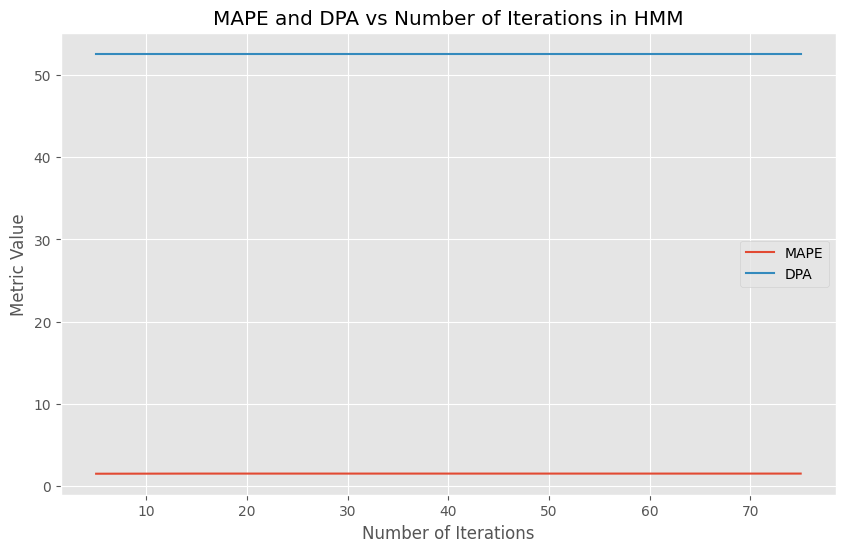

In [ ]:
# Plot the metrics vs iterations
iterations = np.arange(5, 76,10)
plt.figure(figsize=(10, 6))
plt.plot(iterations, mape_history, label='MAPE')
plt.plot(iterations, dpa_history, label='DPA')
plt.xlabel('Number of Iterations')
plt.ylabel('Metric Value')
plt.title('MAPE and DPA vs Number of Iterations in HMM')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 8.2 MB/s eta 0:00:00


In [ ]:
# Télécharger les données historiques de l'action Google
data = yf.download('GOOGL', start='2021-02-10', end='2023-01-21')
print(data.shape)
data = data.dropna()
data.shape

[*********************100%%**********************]  1 of 1 completed

(490, 6)


(490, 6)

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
from sklearn.metrics import mean_absolute_error

# Télécharger les données historiques de l'action Google
data = yf.download('GOOGL', start='2021-02-10', end='2023-01-21')

# Utiliser uniquement les prix de clôture
close = data['Close']

# Calculer les rendements journaliers
returns = close.pct_change().dropna()

# Diviser les données en ensembles d'entraînement et de test
train_size = int(len(returns) * 0.8)
train, test = returns[:train_size], returns[train_size:]

# Spécifier le modèle GARCH(1, 1)
model = arch_model(train, vol='Garch', p=1, q=1)

# Ajuster le modèle aux données d'entraînement
model_fit = model.fit()

# Prédire la volatilité pour l'ensemble de test
forecast = model_fit.forecast(start=0, horizon=len(test))

# Calculer les prédictions de rendement
pred_returns = forecast.variance[-1:].values[0]

# Calculer les prédictions de prix de clôture
pred_close = close[train_size - 1] * (1 + pred_returns)

# Calculer les vrais prix de clôture
true_close = close[train_size+1:]

# Calculer le MAPE
mape = mean_absolute_error(true_close, pred_close) / true_close.mean()

# Calculer le DAP
#dap = np.mean(np.sign(true_close.pct_change()) == np.sign(pred_close.pct_change()))

print(f'MAPE: {mape}')
#print(f'DAP: {dap}')


[*********************100%%**********************]  1 of 1 completed


Iteration:      1,   Func. Count:      6,   Neg. LLF: 121382134.63495228
Iteration:      2,   Func. Count:     17,   Neg. LLF: 418204.6763299516
Iteration:      3,   Func. Count:     27,   Neg. LLF: 183758699.01227212
Iteration:      4,   Func. Count:     38,   Neg. LLF: 1951721.7955349532
Iteration:      5,   Func. Count:     49,   Neg. LLF: 317249.4558127918
Iteration:      6,   Func. Count:     61,   Neg. LLF: 539852.2381198056
Iteration:      7,   Func. Count:     71,   Neg. LLF: -1017.2219812665776
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1017.2219808258067
            Iterations: 11
            Function evaluations: 71
            Gradient evaluations: 7
MAPE: 0.13691449352074653


[*********************100%%**********************]  1 of 1 completed


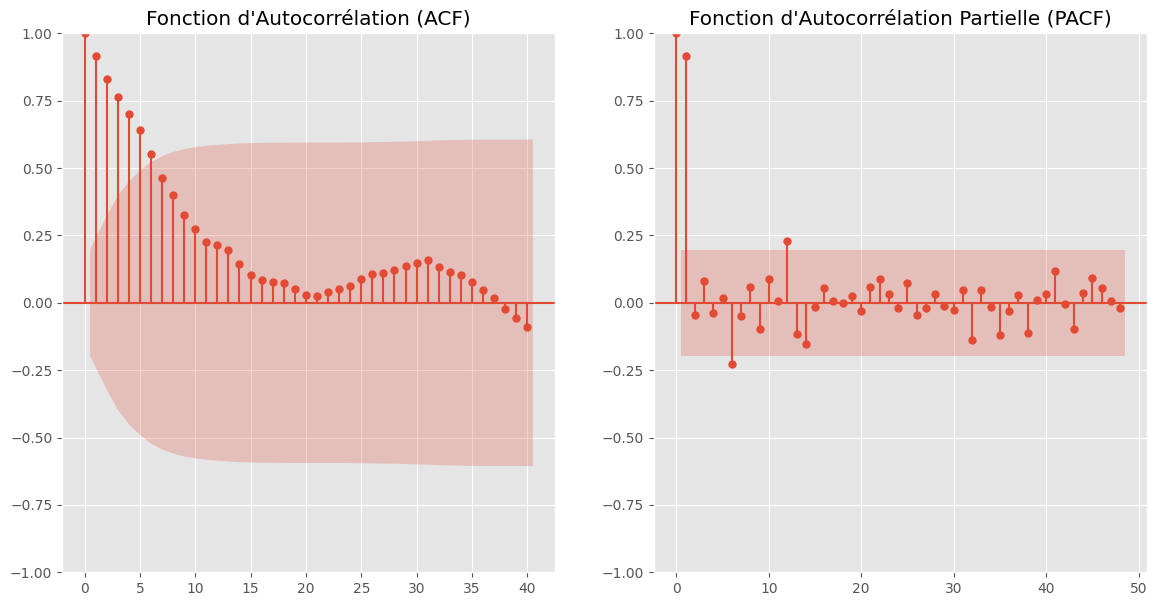

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Télécharger les données historiques de l'action Google
data = yf.download('GOOGL', start='2021-02-10', end='2023-01-21')

# Utiliser uniquement les prix de clôture
close = data['Close']

# Calculer les rendements journaliers
returns = close.pct_change().dropna()

# Diviser les données en ensembles d'entraînement et de test
train_size = int(len(returns) * 0.8)
train, test = returns[:train_size], returns[train_size:]

# Tracer l'ACF
plt.figure(figsize=(14, 7))
plt.subplot(121)  # 1 ligne, 2 colonnes, position 1
plot_acf(close[train_size:], ax=plt.gca(), lags=40)
plt.title('Fonction d\'Autocorrélation (ACF)')

# Tracer le PACF
plt.subplot(122)  # 1 ligne, 2 colonnes, position 2
plot_pacf(close[train_size:], ax=plt.gca(), lags=48)
plt.title('Fonction d\'Autocorrélation Partielle (PACF)')

plt.show()


In [ ]:
!pip install statsmodels


ARIMA MAPE: 0.11800917565615221


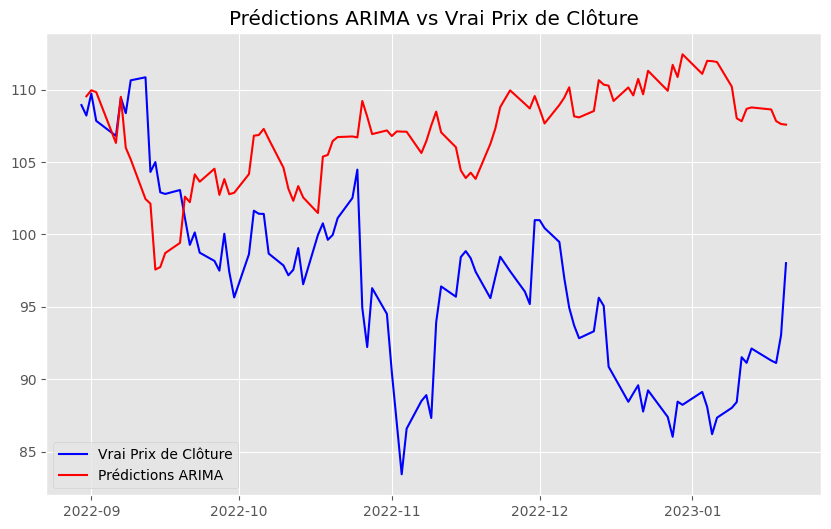

In [ ]:
import statsmodels.api as sm


# ARIMA sur les prix de clôture
arima_model = sm.tsa.ARIMA(close[:train_size], order=(20,1,99))
arima_result = arima_model.fit()

# Prédictions
arima_pred = arima_result.forecast(steps=len(test))

# Calculer le MAPE pour ARIMA
arima_mape = mean_absolute_error(close[train_size+1:], arima_pred) / close[train_size+1:].mean()

# Afficher le MAPE
print(f'ARIMA MAPE: {arima_mape}')

# Visualisation
plt.figure(figsize=(10,6))
plt.plot(close.index[train_size:], close[train_size:], label='Vrai Prix de Clôture', color='blue')
plt.plot(close.index[train_size+1:], arima_pred, label='Prédictions ARIMA', color='red')
plt.title('Prédictions ARIMA vs Vrai Prix de Clôture')
plt.legend()
plt.show()


In [ ]:
def analyze_hidden_states(model, test_data):
    # Prédire les états cachés pour les données de test
    hidden_states = model.predict(test_data)

    # Créer un dictionnaire pour stocker les sous-ensembles de données pour chaque état caché
    hidden_state_data = {state: [] for state in np.unique(hidden_states)}

    # Diviser les données de test en sous-ensembles correspondant à chaque état caché
    for i, state in enumerate(hidden_states):
        hidden_state_data[state].append(test_data[i])

    # Analyser les caractéristiques des données dans chaque sous-ensemble
    for state, data in hidden_state_data.items():
        state_data = np.array(data)
        print(f"État caché {state}:")
        print(f"Nombre d'observations : {len(state_data)}")
        print(f"Moyenne des données : {np.mean(state_data, axis=0)}")
        print(f"Écart-type des données : {np.std(state_data, axis=0)}")
        print(f"Minimum des données : {np.min(state_data, axis=0)}")
        print(f"Maximum des données : {np.max(state_data, axis=0)}")
        print()

# Utilisation de la fonction pour analyser les états cachés
analyze_hidden_states(stock_predictor.hmm, stock_predictor._extract_features(stock_predictor._test_data))


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

class LSTMStockPredictor:
    def __init__(self, company, train_start_date="2005-01-01", train_end_date="2021-09-01", test_start_date="2023-05-01", test_end_date="2024-02-01", window_size=9):
        self.company = company
        self.window_size = window_size
        self.train_start_date = train_start_date
        self.train_end_date = train_end_date
        self.test_start_date = test_start_date
        self.test_end_date = test_end_date
        self.train_data, self.test_data = self._load_data()
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.X_train, self.y_train, self.train_dates = self._prepare_data(self.train_data)
        self.X_test, self.y_test, self.test_dates = self._prepare_data(self.test_data, train=False)
        self.model = self._build_model()

    def _load_data(self):
        train_data = yf.download(self.company, start=self.train_start_date, end=self.train_end_date)
        test_data = yf.download(self.company, start=self.test_start_date, end=self.test_end_date)
        return train_data, test_data

    def _prepare_data(self, data, train=True):
        close_prices = data['Close'].values.reshape(-1, 1)
        scaled_data = self.scaler.fit_transform(close_prices) if train else self.scaler.transform(close_prices)
        X, Y, dates = [], [], []
        for i in range(len(scaled_data) - self.window_size):
            X.append(scaled_data[i:i+self.window_size])
            Y.append(scaled_data[i+self.window_size])
            dates.append(data.iloc[i + self.window_size].name)
        return np.array(X), np.array(Y), dates

    def _build_model(self):
        model = Sequential([
            LSTM(128, return_sequences=True, input_shape=(self.window_size, 1)),
            LSTM(64, return_sequences=False),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer='RMSprop', loss='mse')
        return model

    def fit(self, epochs=100, batch_size=64):
        self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, shuffle=False)

    def predict(self):
        predicted_prices = self.model.predict(self.X_test)
        predicted_prices = self.scaler.inverse_transform(predicted_prices)
        return predicted_prices.flatten()

    def evaluate(self, with_plot=True):
        predicted_prices = self.predict()
        real_prices = self.scaler.inverse_transform(self.y_test).flatten()
        mape = mean_absolute_percentage_error(real_prices, predicted_prices)
        print(f"MAPE: {mape * 100:.2f}%")
        if with_plot:
            plt.figure(figsize=(10,6))
            plt.plot(self.test_dates, real_prices, color='red', label='Real Prices')
            plt.plot(self.test_dates, predicted_prices, color='blue', label='Predicted Prices')
            plt.title(f'{self.company} Stock Price Prediction')
            plt.xlabel('Time')
            plt.ylabel('Price')
            plt.xticks(rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()





[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
46/46 [==============================] - 5s 30ms/step - loss: 0.0011
Epoch 2/100
46/46 [==============================] - 2s 43ms/step - loss: 0.0212
Epoch 3/100
46/46 [==============================] - 2s 45ms/step - loss: 0.0073
Epoch 4/100
46/46 [==============================] - 1s 31ms/step - loss: 0.0034
Epoch 5/100
46/46 [==============================] - 1s 31ms/step - loss: 0.0018
Epoch 6/100
46/46 [==============================] - 1s 31ms/step - loss: 0.0016
Epoch 7/100
46/46 [==============================] - 1s 31ms/step - loss: 0.0014
Epoch 8/100
46/46 [==============================] - 1s 30ms/step - loss: 0.0011
Epoch 9/100
46/46 [==============================] - 1s 31ms/step - loss: 0.0017
Epoch 10/100
46/46 [==============================] - 2s 43ms/step - loss: 9.5716e-04
Epoch 11/100
46/46 [==============================] - 3s 67ms/step - loss: 0.0012
Epoch 12/100
46/46 [==============================] - 3s 69ms/step - loss: 0.0014
Epoch 13/100
46/46 [=

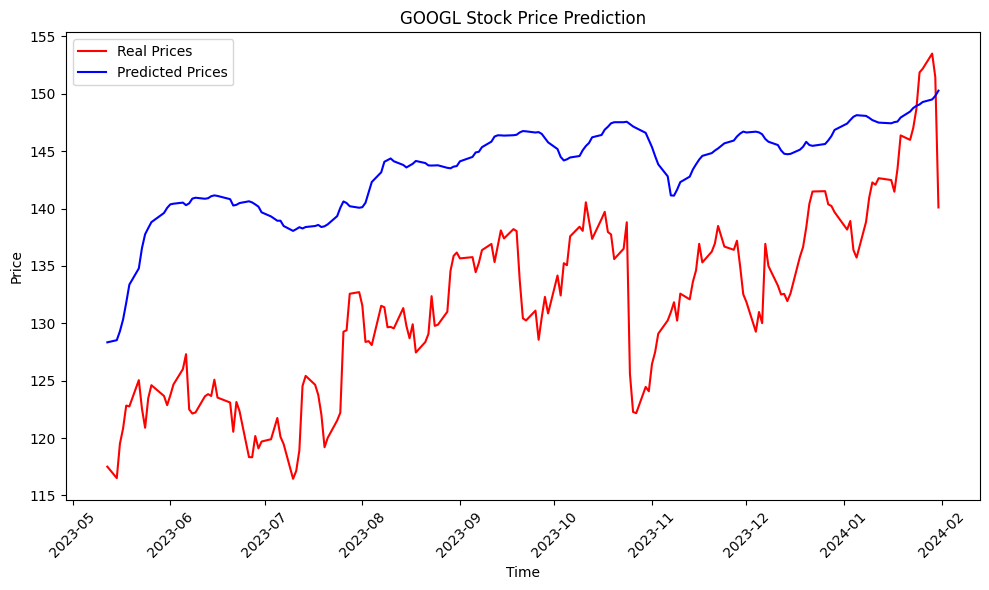

In [ ]:
predictor = LSTMStockPredictor(company="GOOGL",train_start_date="2010-01-01")
predictor.fit()
predictor.evaluate(with_plot=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
50/50 [==============================] - 12s 163ms/step - loss: 0.0069
Epoch 2/50
50/50 [==============================] - 7s 141ms/step - loss: 0.0098
Epoch 3/50
50/50 [==============================] - 8s 163ms/step - loss: 0.0057
Epoch 4/50
50/50 [==============================] - 8s 160ms/step - loss: 0.0038
Epoch 5/50
50/50 [==============================] - 7s 139ms/step - loss: 0.0031
Epoch 6/50
50/50 [==============================] - 8s 164ms/step - loss: 0.0024
Epoch 7/50
50/50 [==============================] - 7s 141ms/step - loss: 0.0017
Epoch 8/50
50/50 [==============================] - 9s 184ms/step - loss: 0.0016
Epoch 9/50
50/50 [==============================] - 8s 167ms/step - loss: 0.0013
Epoch 10/50
50/50 [==============================] - 7s 142ms/step - loss: 0.0012
Epoch 11/50
50/50 [==============================] - 8s 167ms/step - loss: 0.0011
Epoch 12/50
50/50 [==============================] - 8s 156ms/step - loss: 0.0011
Epoch 13/50
50/50 [=====

11/11 [==============================] - 1s 32ms/step
MAPE: 11.23%


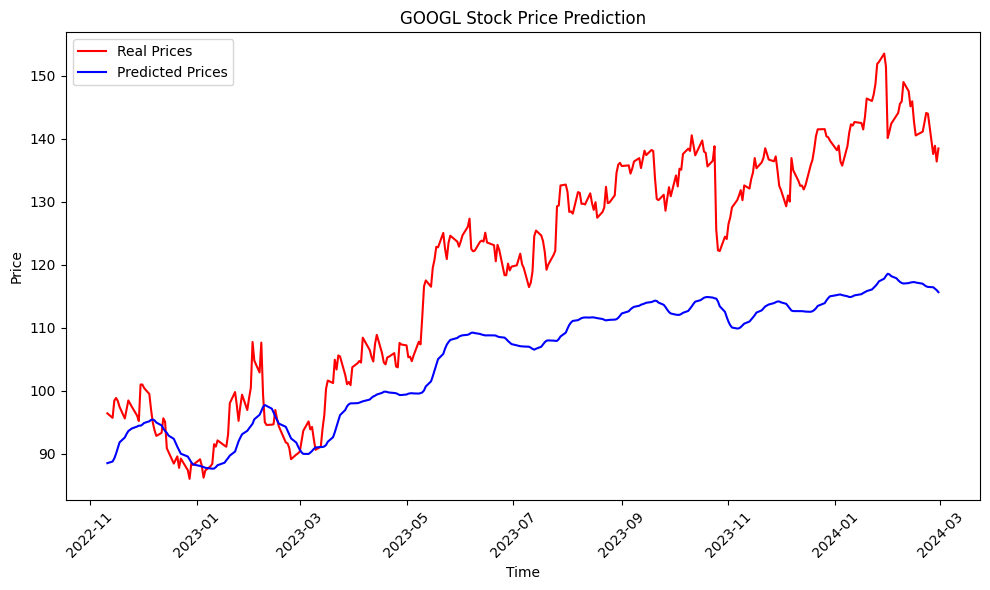

In [ ]:
predictor = LSTMStockPredictor(company="GOOGL",test_end_date="2024-03-01")
predictor.fit()
predictor.evaluate(with_plot=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional
import yfinance as yf

class LSTMCNNStockPredictor:
    def __init__(self, company, train_start_date="2010-01-01", train_end_date="2023-09-01", test_start_date="2024-01-01", test_end_date="2024-03-01", window_size=10):
        self.company = company
        self.window_size = window_size
        self.train_start_date = train_start_date
        self.train_end_date = train_end_date
        self.test_start_date = test_start_date
        self.test_end_date = test_end_date
        self.train_data, self.test_data = self._load_data()
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.X_train, self.y_train = self._prepare_data(self.train_data)
        self.X_test, self.y_test = self._prepare_data(self.test_data, False)
        self.model = self._build_model()

    def _load_data(self):
        train_data = yf.download(self.company, start=self.train_start_date, end=self.train_end_date)
        test_data = yf.download(self.company, start=self.test_start_date, end=self.test_end_date)
        return train_data, test_data

    def _prepare_data(self, data, is_train=True):
        scaled_data = self.scaler.fit_transform(data['Close'].values.reshape(-1, 1)) if is_train else self.scaler.transform(data['Close'].values.reshape(-1, 1))
        X, Y = [], []
        for i in range(len(scaled_data) - self.window_size):
            X.append(scaled_data[i:(i + self.window_size), 0])
            Y.append(scaled_data[i + self.window_size, 0])
        return np.array(X).reshape(-1, self.window_size, 1), np.array(Y).reshape(-1, 1)
    def _build_model(self):
        model = Sequential([
        Conv1D(128, kernel_size=1, activation='relu', input_shape=(self.window_size, 1)),
        MaxPooling1D(2),
        Conv1D(256, kernel_size=1, activation='relu'),
        MaxPooling1D(2),
        Conv1D(512, kernel_size=1, activation='relu'),
        MaxPooling1D(2),
        # Removed Flatten layer
        Bidirectional(LSTM(200, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(200)),
        Dropout(0.5),
        Dense(1, activation='linear')
    ])
        model.compile(optimizer='RMSprop', loss='mse')
        return model



    def fit(self, epochs=200, batch_size=64):
        self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, shuffle=False)

    def predict(self):
        predicted_prices = self.model.predict(self.X_test)
        return self.scaler.inverse_transform(predicted_prices).reshape(-1, 1)

    def evaluate(self, with_plot=True):
        predicted_prices = self.predict().squeeze()
        real_prices = self.test_data['Close'].values[-len(predicted_prices):].reshape(-1, 1)
        if with_plot:
            plt.figure(figsize=(10, 6))
            plt.plot(real_prices, color='black', label='Real Stock Price')
            plt.plot(predicted_prices, color='green', label='Predicted Stock Price')
            plt.title(f'{self.company} Stock Price Prediction')
            plt.xlabel('Time')
            plt.ylabel('Stock Price')
            plt.legend()
            plt.tight_layout()
            plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/200
54/54 [==============================] - 12s 64ms/step - loss: 0.0042
Epoch 2/200
54/54 [==============================] - 4s 77ms/step - loss: 0.0404
Epoch 3/200
54/54 [==============================] - 3s 61ms/step - loss: 0.0321
Epoch 4/200
54/54 [==============================] - 3s 60ms/step - loss: 0.0194
Epoch 5/200
54/54 [==============================] - 4s 79ms/step - loss: 0.0108
Epoch 6/200
54/54 [==============================] - 3s 62ms/step - loss: 0.0064
Epoch 7/200
54/54 [==============================] - 3s 61ms/step - loss: 0.0044
Epoch 8/200
54/54 [==============================] - 3s 61ms/step - loss: 0.0033
Epoch 9/200
54/54 [==============================] - 4s 80ms/step - loss: 0.0028
Epoch 10/200
54/54 [==============================] - 3s 61ms/step - loss: 0.0034
Epoch 11/200
54/54 [==============================] - 3s 61ms/step - loss: 0.0031
Epoch 12/200
54/54 [==============================] - 4s 75ms/step - loss: 0.0030
Epoch 13/200
54/54 [====

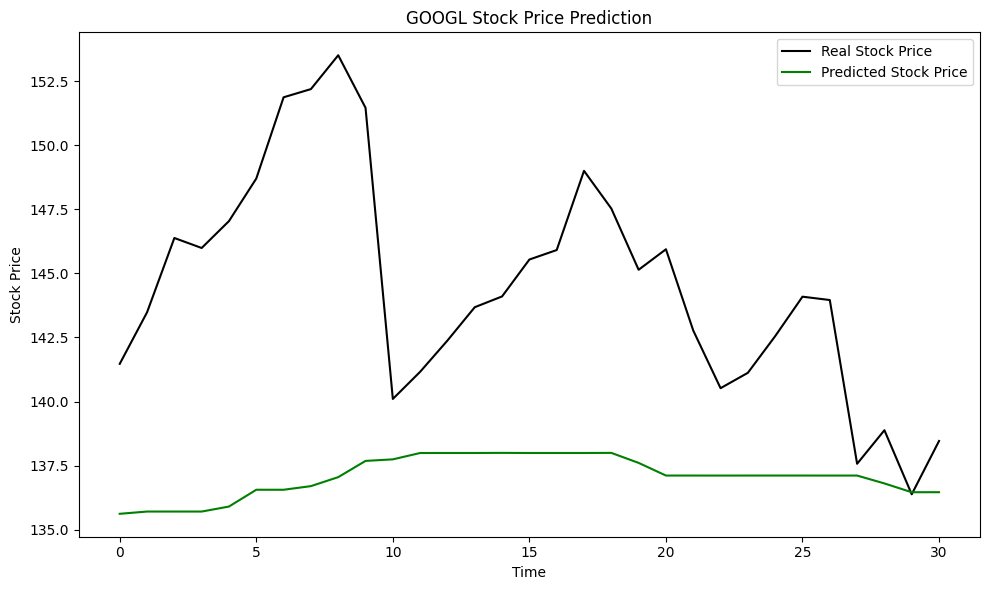

In [ ]:
predictor = LSTMCNNStockPredictor(company="GOOGL")
predictor.fit()
predictor.evaluate()


In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=ab48603d17f9952963ca400461b8fa68e101eb85e1a1534875eb8949ee969fe5
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, TimeDistributed, Flatten
from ta.volatility import BollingerBands
from ta.trend import MACD, IchimokuIndicator
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

class SLSTMStockPrediction:
    def __init__(self, company, train_start_date, train_end_date, test_start_date, test_end_date):
        self.company = company
        self.train_start_date = train_start_date
        self.train_end_date = train_end_date
        self.test_start_date = test_start_date
        self.test_end_date = test_end_date
        self.stock = self.load_data()
        self.add_technical_indicators()
        self.preprocess_data()
        self.model = self.build_model()

    def load_data(self):
        stock = yf.download(self.company, start=self.train_start_date, end=self.test_end_date)
        stock.reset_index(inplace=True)
        return stock

    def add_technical_indicators(self):
        self.stock['macd'] = MACD(close=self.stock["Close"]).macd()
        self.stock['rsi'] = RSIIndicator(close=self.stock["Close"]).rsi()
        self.stock['bb_bbm'] = BollingerBands(close=self.stock["Close"]).bollinger_mavg()
        self.stock['ichi_a'] = IchimokuIndicator(high=self.stock["High"], low=self.stock["Low"]).ichimoku_a()
        self.stock['ichi_b'] = IchimokuIndicator(high=self.stock["High"], low=self.stock["Low"]).ichimoku_b()
        self.stock.fillna(0, inplace=True)

    def preprocess_data(self):
        scaler = MinMaxScaler()
        self.stock.iloc[:, 1:] = scaler.fit_transform(self.stock.iloc[:, 1:])

        self.train_data = self.stock[(self.stock['Date'] >= self.train_start_date) & (self.stock['Date'] <= self.train_end_date)]
        self.test_data = self.stock[(self.stock['Date'] >= self.test_start_date) & (self.stock['Date'] <= self.test_end_date)]

        self.X_train, self.y_train = self.create_dataset(self.train_data)
        self.X_test, self.y_test = self.create_dataset(self.test_data)

    def create_dataset(self, data):
        X, Y = [], []
        window_size = 50
        for i in range(len(data) - window_size - 1):
            X.append(data.iloc[i:i+window_size, 1:].values)
            Y.append(data.iloc[i+window_size, 4])
        return np.array(X), np.array(Y).reshape(-1, 1)

    def build_model(self):
        model = Sequential()
        model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu'), input_shape=(None, 50, self.stock.shape[1] - 1)))
        model.add(TimeDistributed(MaxPooling1D(2)))
        model.add(TimeDistributed(Conv1D(256, kernel_size=1, activation='relu')))
        model.add(TimeDistributed(MaxPooling1D(2)))
        model.add(TimeDistributed(Conv1D(512, kernel_size=1, activation='relu')))
        model.add(TimeDistributed(MaxPooling1D(2)))
        model.add(TimeDistributed(Flatten()))
        model.add(Bidirectional(LSTM(200, return_sequences=True)))
        model.add(Dropout(0.25))
        model.add(Bidirectional(LSTM(200, return_sequences=False)))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit(self, epochs=200):
        self.X_train = self.X_train.reshape(self.X_train.shape[0], 1, 50, self.stock.shape[1] - 1)
        self.X_test = self.X_test.reshape(self.X_test.shape[0], 1, 50, self.stock.shape[1] - 1)
        self.model.fit(self.X_train, self.y_train, validation_data=(self.X_test, self.y_test), epochs=epochs, batch_size=64)

    def evaluate(self):
        predicted = self.model.predict(self.X_test).flatten()
        plt.plot(self.y_test, color='black', label='Actual Stock Price')
        plt.plot(predicted, color='green', label='Predicted Stock Price')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()




[*********************100%%**********************]  1 of 1 completed


Epoch 1/200
50/50 [==============================] - 72s 1s/step - loss: 0.0125 - val_loss: 0.0012
Epoch 2/200
50/50 [==============================] - 9s 171ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 3/200
50/50 [==============================] - 7s 149ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 4/200
50/50 [==============================] - 9s 171ms/step - loss: 0.0011 - val_loss: 0.0094
Epoch 5/200
50/50 [==============================] - 15s 296ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 6/200
50/50 [==============================] - 16s 322ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 7/200
50/50 [==============================] - 14s 271ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 8/200
50/50 [==============================] - 12s 248ms/step - loss: 0.0012 - val_loss: 0.0066
Epoch 9/200
50/50 [==============================] - 9s 186ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 10/200
50/50 [==============================] - 8s 165ms/step - loss: 9.5673e-04 - 

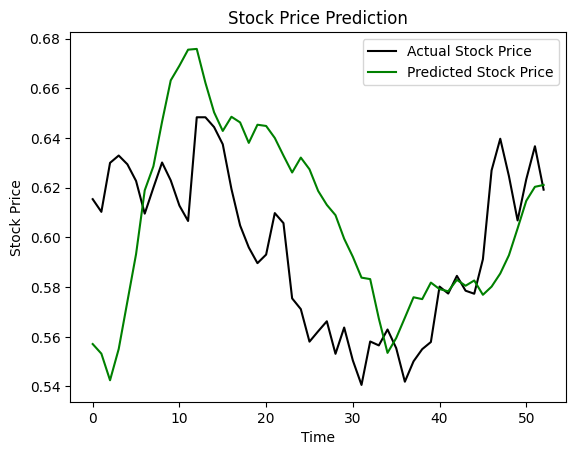

In [ ]:

predictor = SLSTMStockPrediction('GOOGL', '2010-01-01', '2022-09-01', '2022-09-01', '2023-02-01')
predictor.fit()
predictor.evaluate()